Read data

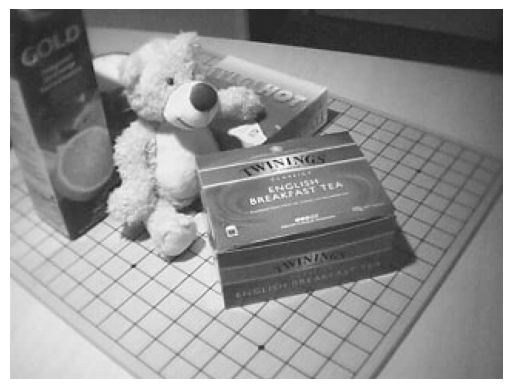

<Figure size 6750x5250 with 0 Axes>

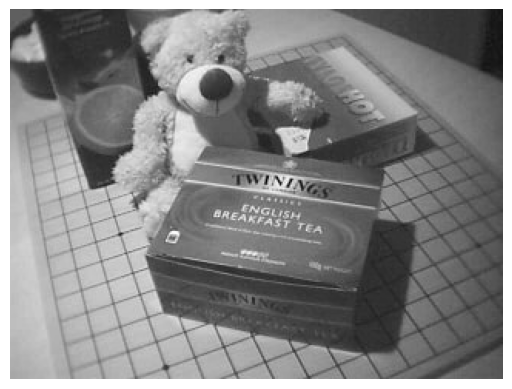

<Figure size 6750x5250 with 0 Axes>

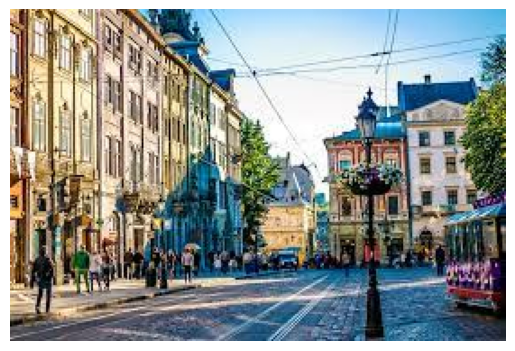

<Figure size 6750x5250 with 0 Axes>

In [206]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def show(img):
    plt.imshow(img)
    plt.axis('off')
    plt.figure(figsize=(45, 35), dpi=150)
    plt.show()

def read(path):
    return cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)

img1 = read('C:\CV\lab2\orig.jpg')
show(img1)

img2 = read('C:\CV\lab2\origChange.jpg')
show(img2)

img3 = read('C:\CV\lab2\lviv.jpg')
show(img3)

Warped image function

In [207]:
def affine(img):
    img = cv.warpAffine(img, np.array([[1, -0.3, 0], [0, 1, 0]]), img1.shape[:2][::-1])
    return img

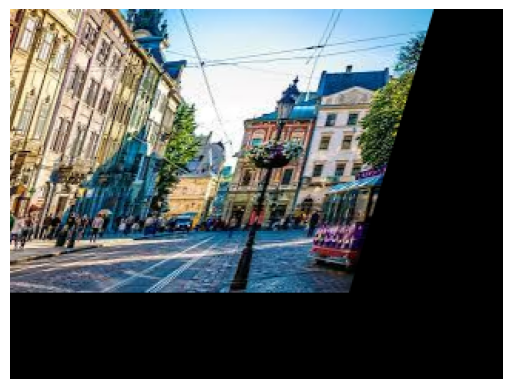

<Figure size 6750x5250 with 0 Axes>

In [208]:
img4 = affine(img3)
show(img4)

Rotate image function

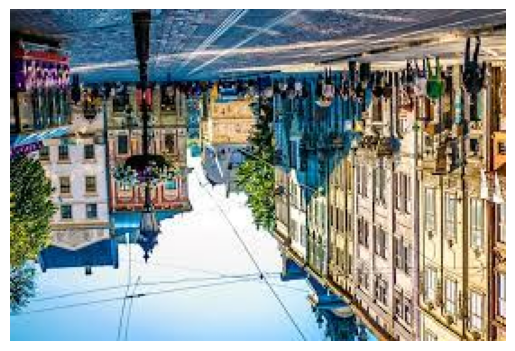

<Figure size 6750x5250 with 0 Axes>

In [209]:
rot_1 = cv.rotate(img3, cv.ROTATE_180)
show(rot_1)

Length between 2 point

In [210]:
def dist(x, y):
  n = len(x)
  assert len(x) == len(y)
  return float(sum([(x[i] ^ y[i]) for i in range(n)]))

Custom matching

In [211]:
def custom_match(img, second):
    orb = cv.ORB_create()

    kp1, des1 = orb.detectAndCompute(img, None)
    kp2, des2 = orb.detectAndCompute(second, None)
    
    matches = []
    for i, k1 in enumerate(des1):
      for j, k2 in enumerate(des2):
        matches.append(cv.DMatch(_distance=dist(k1,k2), _imgIdx=0, _queryIdx=i, _trainIdx=j))

    matches = sorted(matches, key = lambda x : x.distance)

    img3 = cv.drawMatches(img, kp1, second, kp2, matches[:15], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    show(img3)

OpenCV matching

In [212]:
def orb_match(img,second):
    orb = cv.ORB_create()

    kp1, des1 = orb.detectAndCompute(img, None)
    kp2, des2 = orb.detectAndCompute(second, None)

    matches = sorted(
        cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True).match(des1,des2),
        key = lambda x:x.distance)

    img4 = cv.drawMatches(img, kp1, second, kp2, matches[:15], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    show(img4)

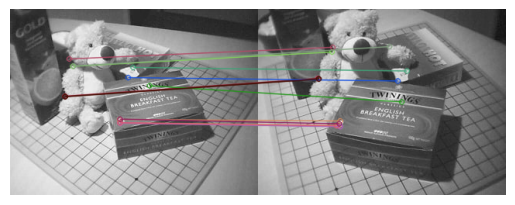

<Figure size 6750x5250 with 0 Axes>

In [213]:
custom_match(img1,img2)

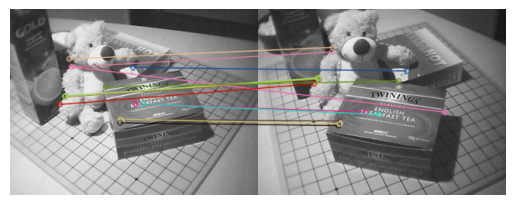

<Figure size 6750x5250 with 0 Axes>

In [214]:
orb_match(img1,img2)

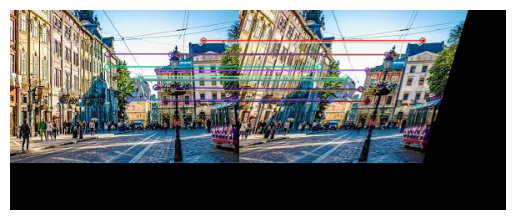

<Figure size 6750x5250 with 0 Axes>

In [215]:
custom_match(img3, img4)


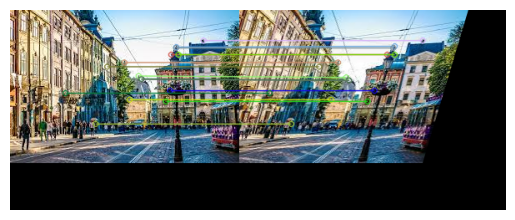

<Figure size 6750x5250 with 0 Axes>

In [216]:
orb_match(img3, img4)

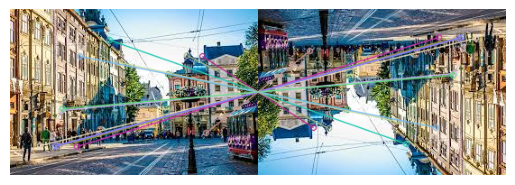

<Figure size 6750x5250 with 0 Axes>

In [217]:
custom_match(img3, rot_1)

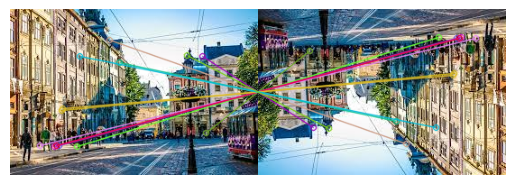

<Figure size 6750x5250 with 0 Axes>

In [218]:
orb_match(img3, rot_1)

# Additional task

In [219]:
import random

def get_point(points, p1):
    return np.array([p1[point.queryIdx].pt for point in points]).reshape(-1,1,2)

In [227]:
def ransac(matches, kp1, kp2, iterations=1000, threshold=5):
    best_inliers = []
    for _ in range(iterations):
        samples = random.sample(matches, 4)
        src_pts = np.array([kp1[sample.queryIdx].pt for sample in samples]).reshape(-1,1,2)
        dst_pts = np.array([kp2[sample.trainIdx].pt for sample in samples]).reshape(-1,1,2)
        H, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, threshold)

        inliers = []
        for sample in matches:
            src_pt = np.array(kp1[sample.queryIdx].pt).reshape(-1,1,2)
            dst_pt = np.array(kp2[sample.trainIdx].pt).reshape(-1,1,2)
            transformed_pt = cv.perspectiveTransform(src_pt, H)
            dist = np.linalg.norm(dst_pt - transformed_pt)
            if dist < threshold:
                inliers.append(sample)

        if len(inliers) > len(best_inliers):
            best_inliers = inliers

    src_pts = np.array([kp1[sample.queryIdx].pt for sample in best_inliers]).reshape(-1,1,2)
    dst_pts = np.array([kp2[sample.trainIdx].pt for sample in best_inliers]).reshape(-1,1,2)
    H, _ = cv.findHomography(src_pts, dst_pts, 0)

    return H, best_inliers

In [228]:
def orb_ransac_matcher(img, second):
    orb = cv.ORB_create()

    kp1, des1 = orb.detectAndCompute(img, None)
    kp2, des2 = orb.detectAndCompute(second, None)
    
    matches = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True).match(des1,des2)

    H, inliers = ransac(matches, kp1, kp2)

    flag = cv.drawMatches(img, kp1, second, kp2, inliers[:15], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    show(flag)

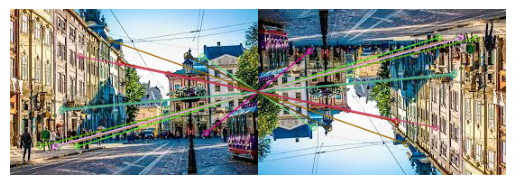

<Figure size 6750x5250 with 0 Axes>

In [229]:
orb_ransac_matcher(img3, rot_1)

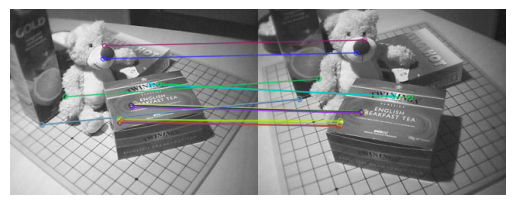

<Figure size 6750x5250 with 0 Axes>

In [230]:
orb_ransac_matcher(img1, img2)